My Replication of Ethan Dinh's findings

Final shape after preprocessing: (7158, 63)
Columns used (63):
['schedule_season', 'schedule_week', 'schedule_playoff', 'temp', 'total_home_epa', 'total_home_rush_epa', 'total_home_pass_epa', 'home_qb_epa', 'total_away_epa', 'total_away_rush_epa', 'total_away_pass_epa', 'away_qb_epa', 'home_wp', 'away_wp', 'spread_line', 'total_line', 'spread_favorite', 'over_under_line', 'has_betting_line', 'result', 'home_favorite', 'home_def_plays_faced', 'home_def_total_yards_allowed', 'home_def_pass_yards_allowed', 'home_def_rush_yards_allowed', 'home_def_yards_per_play_allowed', 'home_def_epa_allowed', 'home_def_epa_per_play_allowed', 'home_def_success_rate_allowed', 'home_def_sacks', 'home_def_interceptions', 'home_def_forced_fumbles', 'home_def_fumbles_recovered', 'home_def_explosive_passes_allowed', 'home_def_explosive_runs_allowed', 'home_def_explosive_plays_allowed', 'home_def_qb_hits', 'home_def_pressures', 'home_def_dropbacks', 'home_def_pressure_rate', 'home_def_points_allowed', 'home_def

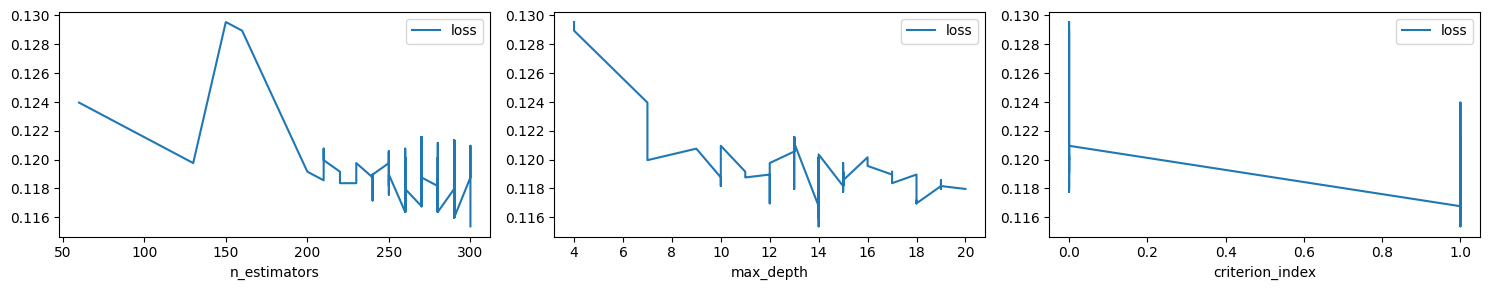


Logistic Regression C Parameter Tuning


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

Best Score: 0.8888223552894212
Best Hyperparameters: {'C': 0.001}


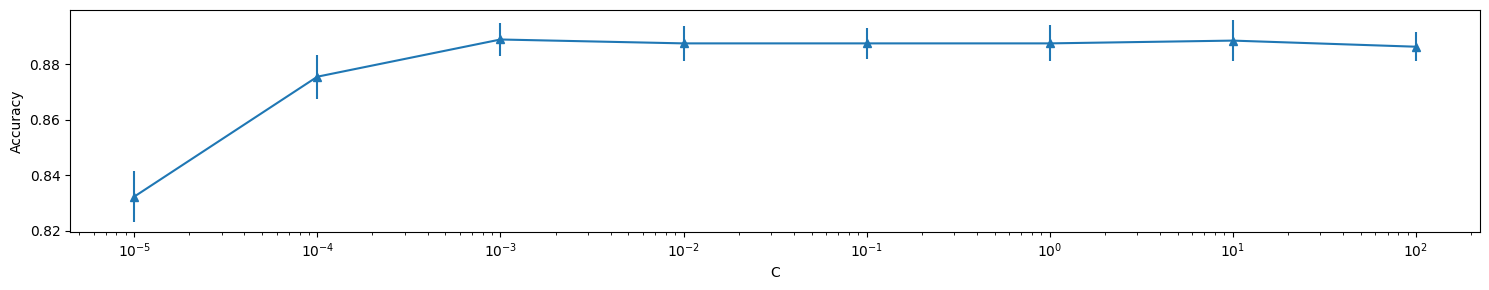

Best C parameter: 0.001

XGBoost Hyperparameter Tuning
100%|██████████| 100/100 [09:13<00:00,  5.53s/trial, best loss: 0.11457085828343305]
Best XGB (Hyperopt): {'xgb_learning_rate': 0.013413910048382898, 'xgb_max_depth': 2.0, 'xgb_n_estimators': 1500.0}


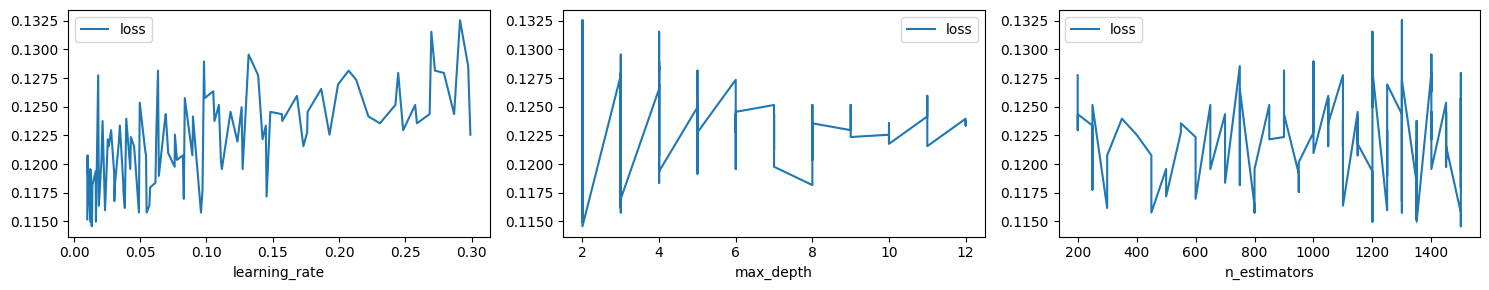


Training Models with Tuned Parameters
All tuned models trained successfully!

=== Random Forest (tuned) ===
Accuracy:  0.8696
Precision: 0.8709
Recall:    0.9026
F1:        0.8865
AUROC:     0.9453


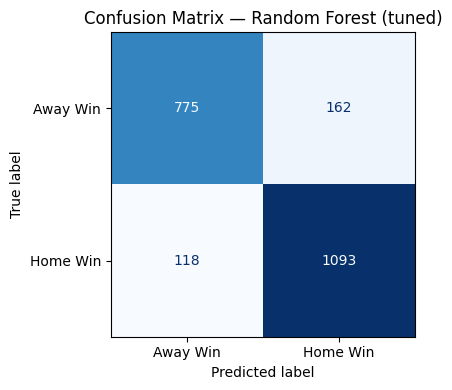


=== Logistic Regression (scaled) ===
Accuracy:  0.8571
Precision: 0.8537
Recall:    0.9009
F1:        0.8767
AUROC:     0.9375


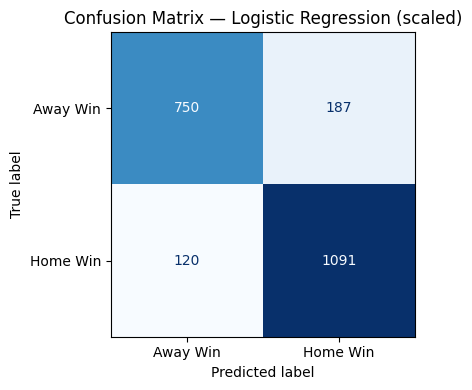


=== XGBoost (tuned) ===
Accuracy:  0.8757
Precision: 0.8752
Recall:    0.9092
F1:        0.8919
AUROC:     0.9518


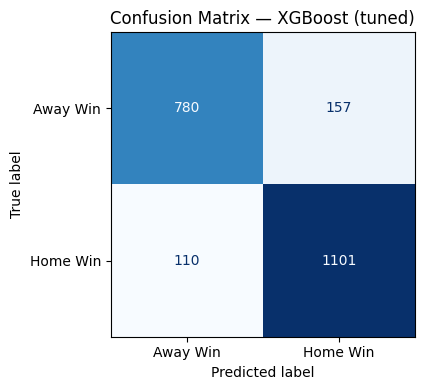


Summary:
                           Model       acc      prec       rec        f1  \
0         Random Forest (tuned)  0.869646  0.870916  0.902560  0.886456   
1  Logistic Regression (scaled)  0.857076  0.853678  0.900908  0.876657   
2               XGBoost (tuned)  0.875698  0.875199  0.909166  0.891859   

      auroc  
0  0.945319  
1  0.937471  
2  0.951795  

CV Acc — RF: [0.8764 0.8715 0.8987 0.8749 0.8686] mean: 0.878
CV Acc — LR: [0.8568 0.8645 0.8834 0.8665 0.8609] mean: 0.8664
Paired t-test (H1: LR > RF): t=-4.649, p=0.995167

EXTRAPOLATION: Testing on 2019+ Data (Voting Classifier)
Extrapolation datasets prepared:
Train (pre-2019): (5307, 42)
Test (2019+):     (1851, 42)
Model Win Percentage: 0.9199
Total Number of Bets Won: 1561
Total Number of Bets Made: 1697
Possible Games (2019+): 1851

PREDICTION: Week 13, 2025 Games (Season-to-date OFF + DEF)
 schedule_season  schedule_week             team_home            team_away  pred_home_win_prob     predicted_winner
          

In [2]:
#!/usr/bin/env python3

import os, numpy as np, pandas as pd
from scipy import stats as scipy_stats
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, anneal

SEED = 42
np.random.seed(SEED)
os.makedirs("outputs", exist_ok=True)

TEAM_FULL = {
    "ARI": "Arizona Cardinals",
    "ATL": "Atlanta Falcons",
    "BAL": "Baltimore Ravens",
    "BUF": "Buffalo Bills",
    "CAR": "Carolina Panthers",
    "CHI": "Chicago Bears",
    "CIN": "Cincinnati Bengals",
    "CLE": "Cleveland Browns",
    "DAL": "Dallas Cowboys",
    "DEN": "Denver Broncos",
    "DET": "Detroit Lions",
    "GB":  "Green Bay Packers",
    "HOU": "Houston Texans",
    "IND": "Indianapolis Colts",
    "JAX": "Jacksonville Jaguars",
    "KC":  "Kansas City Chiefs",
    "LV":  "Las Vegas Raiders",
    "LAC": "Los Angeles Chargers",
    "LA": "Los Angeles Rams",
    "MIA": "Miami Dolphins",
    "MIN": "Minnesota Vikings",
    "NE":  "New England Patriots",
    "NO":  "New Orleans Saints",
    "NYG": "New York Giants",
    "NYJ": "New York Jets",
    "PHI": "Philadelphia Eagles",
    "PIT": "Pittsburgh Steelers",
    "SF":  "San Francisco 49ers",
    "SEA": "Seattle Seahawks",
    "TB":  "Tampa Bay Buccaneers",
    "TEN": "Tennessee Titans",
    "WAS": "Washington Commanders",
}

OFFENSE_PATH = "Data/offensive_team_logs_from_nfl_data_py_2014_2025.csv"
DEFENSE_PATH = "Data/team_defense_game_logs_2014_2024.csv"

off = pd.read_csv(OFFENSE_PATH)
defense = pd.read_csv(DEFENSE_PATH)

TEAM_ABBR_NORMALIZE = {
    "OAK": "LV",
    "STL": "LAR",
    "SD":  "LAC",
}

# Offense abbreviations
for col in ["home_abbr", "away_abbr"]:
    if col in off.columns:
        off[col] = off[col].replace(TEAM_ABBR_NORMALIZE)

# Defense abbreviations 
for col in ["defteam", "offteam", "home_team", "away_team"]:
    if col in defense.columns:
        defense[col] = defense[col].replace(TEAM_ABBR_NORMALIZE)


# One row per game with final home/away scores
score_meta = (
    off[["game_id", "score_home", "score_away"]]
    .drop_duplicates("game_id")
    .copy()
)

# Drop data that could potentially cause leakage
defense = defense.drop(
    columns=[
        "points_allowed",
        "points_scored_by_team",
        "home_score_final",
        "away_score_final",
        "result",
    ],
    errors="ignore",
)

# Join scores onto defense by game_id
defense = defense.merge(score_meta, on="game_id", how="left")

# Recompute defensive points allowed / scored / result
def get_points_allowed(row):
    if row["defteam"] == row["home_team"]:
        return row["score_away"]
    if row["defteam"] == row["away_team"]:
        return row["score_home"]
    return np.nan 

def get_points_scored(row):
    if row["defteam"] == row["home_team"]:
        return row["score_home"]
    if row["defteam"] == row["away_team"]:
        return row["score_away"]
    return np.nan

defense["points_allowed"] = defense.apply(get_points_allowed, axis=1)
defense["points_scored_by_team"] = defense.apply(get_points_scored, axis=1)
defense["result"] = defense["points_scored_by_team"] - defense["points_allowed"]

# Drop offensive score columns so they don't leak into features
defense = defense.drop(columns=["score_home", "score_away"], errors="ignore")

# Building df

df = off.copy()

df["result"] = np.where(
    df["score_home"] > df["score_away"], 1,
    np.where(df["score_home"] < df["score_away"], 0, np.nan)
)

# Drop games without a clear winner (ties)
df = df.dropna(subset=["result"]).copy()
df["result"] = df["result"].astype(int)

df["schedule_date"] = pd.to_datetime(df["schedule_date"])
df["schedule_playoff"] = df["schedule_playoff"].astype(int)

df["home_favorite"] = np.where(
    df["spread_line"] < 0, 1,
    np.where(df["spread_line"] > 0, 0, np.nan)
)
df["home_favorite"] = df["home_favorite"].fillna(0).astype(int)

def prep_def(df_def, side_prefix, team_col_name):
    df_def = df_def.copy()
    drop_cols = [
        "season", "week", "season_type", "offteam",
        "home_team", "away_team", "is_home",
        "result", "home_score_final", "away_score_final",
        "score_home", "score_away",
    ]
    for c in drop_cols:
        if c in df_def.columns:
            df_def = df_def.drop(columns=c)

    # Rename team id column to match offensive df key
    df_def = df_def.rename(columns={"defteam": team_col_name})

    key_cols = ["game_id", team_col_name]
    rename_map = {c: f"{side_prefix}_{c}" for c in df_def.columns if c not in key_cols}
    df_def = df_def.rename(columns=rename_map)

    return df_def

home_def = defense[defense["is_home"] == 1]
away_def = defense[defense["is_home"] == 0]

home_def_prepped = prep_def(home_def, "home_def", "home_abbr")
away_def_prepped = prep_def(away_def, "away_def", "away_abbr")

# Merge home and away defense onto the offensive game table
df = df.merge(home_def_prepped, on=["game_id", "home_abbr"], how="left")
df = df.merge(away_def_prepped, on=["game_id", "away_abbr"], how="left")

if "weather" in df.columns:
    df = df.drop(columns=["weather"])

df["temp"] = pd.to_numeric(df["temp"], errors="coerce")

num_cols_all = df.select_dtypes(include=[np.number]).columns
df[num_cols_all] = df[num_cols_all].fillna(df[num_cols_all].mean())

df_meta = df[["schedule_season", "schedule_week", "team_home", "team_away"]].copy()

drop_candidates = [
    "game_id",
    "schedule_date",
    "team_home", "team_away",
    "home_abbr", "away_abbr",
    "score_home", "score_away",
    "home_wp_post", "away_wp_post",
    "game_result",
]

drop_cols = [c for c in drop_candidates if c in df.columns]
df_proc = df.drop(columns=drop_cols)

# Use this as the main modeling dataframe going forward
df = df_proc.copy()

print("Final shape after preprocessing:", df.shape)
print("Columns used ({}):".format(len(df.columns)))
print(df.columns.tolist())

print("\nSample of preprocessed data (first 10 rows):")
print(df.head(10).to_string())

X = df.drop(columns=["result"])
y = df["result"].copy()


drop_leakage = [
    "home_def_points_allowed",
    "home_def_points_scored_by_team",
    "away_def_points_allowed",
    "away_def_points_scored_by_team",
    "total_home_epa",
    "total_home_rush_epa",
    "total_home_pass_epa",
    "home_qb_epa",
    "total_away_epa",
    "total_away_rush_epa",
    "total_away_pass_epa",
    "away_qb_epa",
    "home_wp", "away_wp",
    "spread_line", "total_line",
    "over_under_line",
    "spread_favorite",
    "home_favorite",
    "has_betting_line",
]

X = X.drop(columns=[c for c in drop_leakage if c in X.columns])

print("\nColumns used after leakage cleanup ({}):".format(len(X.columns)))
print(X.columns.tolist())


print("\nX shape:", X.shape)
print("Home-win rate (label mean):", y.mean().round(3))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=SEED
)

print("Train/Test sizes:", X_train.shape, X_test.shape)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
scale_transformer = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)


# Hyperparameter tuning

print("Random Forest Hyperparameter Tuning")

RF = RandomForestClassifier(random_state=SEED, n_jobs=-1)
LR = LogisticRegression()
xg_classify = XGBClassifier()

def RF_objective(params):

    model = RandomForestClassifier(
        n_estimators=int(params['rf_n_estimators']),
        max_depth=int(params['rf_max_depth']),
        criterion=params['rf_criterion'], 
        random_state=SEED,
        n_jobs=-1
    )
    error = 1 - cross_val_score(
        model, X_train, y_train, cv=5, scoring='accuracy'
    ).mean()
    return {'loss': error, 'status': STATUS_OK}

RF_parameter_space = { 
    'rf_n_estimators': hp.quniform('rf_n_estimators', 50, 300, 10),
    'rf_max_depth': hp.quniform('rf_max_depth', 2, 20, 1),
    'rf_criterion': hp.choice('rf_criterion', ['gini', 'entropy'])
}

RF_trials = Trials()
RF_best_params = fmin(
    fn=RF_objective,
    space=RF_parameter_space,
    algo=anneal.suggest, 
    max_evals=100,
    trials=RF_trials
)

print("Best RF (Hyperopt):", RF_best_params)

criterion_options = ['gini', 'entropy']
best_rf_n_estimators = int(RF_best_params['rf_n_estimators'])
best_rf_max_depth = int(RF_best_params['rf_max_depth'])
best_rf_criterion = criterion_options[RF_best_params['rf_criterion']]

RF_search_results = pd.DataFrame({
    'loss': RF_trials.losses(), 
    'n_estimators': RF_trials.vals['rf_n_estimators'],
    'max_depth': RF_trials.vals['rf_max_depth'],
    'criterion_index': RF_trials.vals['rf_criterion']
})

fig, subPlots = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
RF_search_results.sort_values(by='n_estimators').plot(x='n_estimators', y='loss', ax=subPlots[0])
RF_search_results.sort_values(by='max_depth').plot(x='max_depth', y='loss', ax=subPlots[1])
RF_search_results.sort_values(by='criterion_index').plot(x='criterion_index', y='loss', ax=subPlots[2])

plt.tight_layout()
plt.savefig("outputs/rf_hyperopt_tuning.png", bbox_inches="tight", dpi=300)
plt.show()

# Logistic Regression C-sweep

print("\nLogistic Regression C Parameter Tuning")

space = dict()
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

search = GridSearchCV(LR, space, scoring='accuracy', n_jobs=-1, cv=5)
LR_result = search.fit(X_train, y_train)

print('Best Score: %s' % LR_result.best_score_)
print('Best Hyperparameters: %s' % LR_result.best_params_)

scores = LR_result.cv_results_
means_test = scores["mean_test_score"]
std_test = scores["std_test_score"]
x_vals = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

fig = plt.figure(figsize=(15, 3))
plt.errorbar(x_vals, means_test, std_test, marker='^')
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

best_C = LR_result.best_params_['C']
print(f"Best C parameter: {best_C}")

# XGBoost Hyperopt

print("\nXGBoost Hyperparameter Tuning")

def XGB_objective(params):

    model = XGBClassifier(
        learning_rate=params['xgb_learning_rate'],
        max_depth=int(params['xgb_max_depth']),
        n_estimators=int(params['xgb_n_estimators']),
        random_state=SEED,
        eval_metric="logloss",
        n_jobs=-1
    )
    error = 1 - cross_val_score(
        model, X_train, y_train, cv=5, scoring='accuracy'
    ).mean()
    return {'loss': error, 'status': STATUS_OK}

XGB_parameter_space = {
    "xgb_learning_rate": hp.uniform("xgb_learning_rate", 0.01, 0.3),
    "xgb_max_depth": hp.quniform("xgb_max_depth", 2, 12, 1),
    "xgb_n_estimators": hp.quniform("xgb_n_estimators", 200, 1500, 50),
}

XGB_trials = Trials()
XGB_best_params = fmin(
    fn=XGB_objective,
    space=XGB_parameter_space,
    algo=tpe.suggest, 
    max_evals=100,
    trials=XGB_trials
)

print("Best XGB (Hyperopt):", XGB_best_params)

best_xgb_learning_rate = XGB_best_params['xgb_learning_rate']
best_xgb_max_depth = int(XGB_best_params['xgb_max_depth'])
best_xgb_n_estimators = int(XGB_best_params['xgb_n_estimators'])

XGB_search_results = pd.DataFrame({
    'loss': XGB_trials.losses(), 
    'learning_rate': XGB_trials.vals['xgb_learning_rate'],
    'max_depth': XGB_trials.vals['xgb_max_depth'],
    'n_estimators': XGB_trials.vals['xgb_n_estimators']
})

fig, subPlots = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
XGB_search_results.sort_values(by='learning_rate').plot(x='learning_rate', y='loss', ax=subPlots[0])
XGB_search_results.sort_values(by='max_depth').plot(x='max_depth', y='loss', ax=subPlots[1])
XGB_search_results.sort_values(by='n_estimators').plot(x='n_estimators', y='loss', ax=subPlots[2])

plt.tight_layout()
plt.savefig("outputs/xgb_hyperopt_tuning.png", bbox_inches="tight", dpi=300)
plt.show()

# Models with tuned parameters

print("\nTraining Models with Tuned Parameters")

rf = RandomForestClassifier(
    n_estimators=best_rf_n_estimators,
    max_depth=best_rf_max_depth,
    criterion=best_rf_criterion,
    random_state=SEED,
    n_jobs=-1
)

lr = LogisticRegression(
    C=best_C,
    max_iter=5000,
    random_state=SEED
)

xgb = XGBClassifier(
    learning_rate=best_xgb_learning_rate,
    n_estimators=best_xgb_n_estimators,
    max_depth=best_xgb_max_depth,
    random_state=SEED,
    eval_metric="logloss",
    n_jobs=-1
)

# Scale features for Logistic Regression
X_train_scaled = scale_transformer.fit_transform(X_train)
X_test_scaled = scale_transformer.transform(X_test)

# Fit all models
rf.fit(X_train, y_train)
lr.fit(X_train_scaled, y_train)
xgb.fit(X_train, y_train)

print("All tuned models trained successfully!")


# Evaluation helper

def evaluate(name, model, X_tst=X_test, y_tst=y_test, scaled=False):
    if scaled:
        X_tst_scaled = scale_transformer.transform(X_tst)
        y_pred = model.predict(X_tst_scaled)
        y_proba = model.predict_proba(X_tst_scaled)[:, 1]
    else:
        y_pred = model.predict(X_tst)
        y_proba = model.predict_proba(X_tst)[:, 1]

    acc = accuracy_score(y_tst, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_tst, y_pred, average="binary", zero_division=0
    )
    auroc = roc_auc_score(y_tst, y_proba)

    print(f"\n{name}")
    print(
        f"Accuracy:  {acc:.4f}\n"
        f"Precision: {prec:.4f}\n"
        f"Recall:    {rec:.4f}\n"
        f"F1:        {f1:.4f}\n"
        f"AUROC:     {auroc:.4f}"
    )
    cm = confusion_matrix(y_tst, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Away Win", "Home Win"]
    )
    fig, ax = plt.subplots(figsize=(4.5, 4))
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.savefig(
        f"outputs/{name.lower().replace(' ','_')}_confusion_matrix.png",
        bbox_inches="tight",
    )
    plt.show()

    return dict(Model=name, acc=acc, prec=prec, rec=rec, f1=f1, auroc=auroc)



# Evaluate tuned models on held-out test set

summary = []
summary.append(evaluate("Random Forest (tuned)", rf))
summary.append(
    evaluate("Logistic Regression (scaled)", lr, X_test, y_test, scaled=True)
)
summary.append(evaluate("XGBoost (tuned)", xgb))
print("\nSummary:\n", pd.DataFrame(summary))

# Cross-Validation Scores

def cv_scores(model, X, y, k=5, seed=SEED, scaled=False):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    scores = []
    for train_idx, test_idx in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        if scaled:
            num_cols_local = X.select_dtypes(include=[np.number]).columns.tolist()
            local_scaler = ColumnTransformer(
                transformers=[("num", StandardScaler(), num_cols_local)],
                remainder="passthrough",
                verbose_feature_names_out=False,
            )
            X_train_scaled = local_scaler.fit_transform(X_train_fold)
            X_test_scaled = local_scaler.transform(X_test_fold)
            model.fit(X_train_scaled, y_train_fold)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_test_fold)

        scores.append(accuracy_score(y_test_fold, y_pred))
    return np.array(scores)


rf_cv_scores = cv_scores(rf, X, y)
lr_cv_scores = cv_scores(lr, X, y, scaled=True)
print(
    "\nCV Acc — RF:", np.round(rf_cv_scores, 4),
    "mean:", rf_cv_scores.mean().round(4)
)
print(
    "CV Acc — LR:", np.round(lr_cv_scores, 4),
    "mean:", lr_cv_scores.mean().round(4)
)
t_stat, p_val = scipy_stats.ttest_rel(
    lr_cv_scores, rf_cv_scores, alternative="greater"
)
print(f"Paired t-test (H1: LR > RF): t={t_stat:.3f}, p={p_val:.6f}")

# Extrapolation: train on pre-2019, test on 2019+ (voting classifier)

print("EXTRAPOLATION: Testing on 2019+ Data (Voting Classifier)")

from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

# Masks based on season from df_meta 
train_mask = df_meta["schedule_season"] < 2019
test_mask  = df_meta["schedule_season"] >= 2019

# Features and labels aligned with those masks
train_x = X.loc[train_mask].copy()
train_y = y.loc[train_mask].copy()
test_x  = X.loc[test_mask].copy()
test_y  = y.loc[test_mask].copy()  

# Metadata for betting results
test_meta = df_meta.loc[test_mask].copy()

print("Extrapolation datasets prepared:")
print(f"Train (pre-2019): {train_x.shape}")
print(f"Test (2019+):     {test_x.shape}")

# Voting classifier with our tuned hyperparameters

boost = XGBClassifier(
    learning_rate=best_xgb_learning_rate,
    n_estimators=best_xgb_n_estimators,
    max_depth=best_xgb_max_depth,
    random_state=SEED,
    eval_metric="logloss",
    n_jobs=-1,
)
RF_v = RandomForestClassifier(
    n_estimators=best_rf_n_estimators,
    max_depth=best_rf_max_depth,
    criterion=best_rf_criterion,
    random_state=SEED,
    n_jobs=-1,
)
LR_v = LogisticRegression(
    C=best_C,
    max_iter=5000,
    random_state=SEED,
)

vote = VotingClassifier(
    estimators=[("boost", boost), ("LR", LR_v), ("RF", RF_v)],
    voting="soft",
)

model_cal = CalibratedClassifierCV(vote, method="isotonic", cv=3)
model_cal.fit(train_x, train_y)

predicted = model_cal.predict_proba(test_x)[:, 1] 

test_df = test_meta.copy()
test_df["hm_won_prob"] = predicted
test_df["result"] = test_y.values

# Simple betting rule ---> bet if prob >= 0.60 or <= 0.40
test_df["my_bet_won"] = (
    ((test_df.hm_won_prob >= 0.60) & (test_df.result == 1))
    | ((test_df.hm_won_prob <= 0.40) & (test_df.result == 0))
).astype(int)

test_df["my_bet_lost"] = (
    ((test_df.hm_won_prob >= 0.60) & (test_df.result == 0))
    | ((test_df.hm_won_prob <= 0.40) & (test_df.result == 1))
).astype(int)

num_won = test_df.my_bet_won.sum()
num_bets = (test_df.my_bet_won + test_df.my_bet_lost).sum()

if num_bets > 0:
    print("Model Win Percentage: " + "{:.4f}".format(num_won / num_bets))
    print("Total Number of Bets Won: " + str(num_won))
    print("Total Number of Bets Made: " + str(num_bets))
else:
    print("No bets placed under the 0.60 / 0.40 threshold rule.")
print("Possible Games (2019+): " + str(len(test_df)))


# Prediction: Week 13, 2025 games using season-to-date OFF + DEF
# Demonstrates real world use of the machine

print("PREDICTION: Week 13, 2025 Games (Season-to-date OFF + DEF)")

w13_raw = off[(off["schedule_season"] == 2025) & (off["schedule_week"] == 13)].copy()

if w13_raw.empty:
    print("No Week 13 2025 games found in the offensive CSV.")
else:
    # Normalize abbreviations
    for col in ["home_abbr", "away_abbr"]:
        if col in w13_raw.columns:
            w13_raw[col] = w13_raw[col].replace(TEAM_ABBR_NORMALIZE)

    for side in ["home", "away"]:
        name_col = f"team_{side}"
        abbr_col = f"{side}_abbr"
        if (name_col in w13_raw.columns) and (abbr_col in w13_raw.columns):
            w13_raw[name_col] = w13_raw[name_col].fillna(
                w13_raw[abbr_col].map(TEAM_FULL)
            )

    # Building offensive aggregates
            
    past_off = off[
        (off["schedule_season"] == 2025) & (off["schedule_week"] <= 12)
    ].copy()

    # Potential offensive stat columns from home/away
    home_off_cols = [
        "total_home_epa",
        "total_home_rush_epa",
        "total_home_pass_epa",
        "home_qb_epa",
    ]
    away_off_cols = [
        "total_away_epa",
        "total_away_rush_epa",
        "total_away_pass_epa",
        "away_qb_epa",
    ]
    home_off_cols = [c for c in home_off_cols if c in past_off.columns]
    away_off_cols = [c for c in away_off_cols if c in past_off.columns]

    home_off = past_off[["home_abbr"] + home_off_cols].copy()
    rename_home = {"home_abbr": "team_abbr"}
    for c in home_off_cols:
        if c.startswith("total_home_"):
            base = c.replace("total_home_", "")
            rename_home[c] = f"off_{base}"
        elif c == "home_qb_epa":
            rename_home[c] = "off_qb_epa"
    home_off = home_off.rename(columns=rename_home)

    # Away offense
    away_off = past_off[["away_abbr"] + away_off_cols].copy()
    rename_away = {"away_abbr": "team_abbr"}
    for c in away_off_cols:
        if c.startswith("total_away_"):
            base = c.replace("total_away_", "")
            rename_away[c] = f"off_{base}"
        elif c == "away_qb_epa":
            rename_away[c] = "off_qb_epa"
    away_off = away_off.rename(columns=rename_away)

    off_team = pd.concat([home_off, away_off], ignore_index=True)
    off_num_cols = [c for c in off_team.columns if c != "team_abbr" and
                    np.issubdtype(off_team[c].dtype, np.number)]
    off_team_agg = (
        off_team.groupby("team_abbr")[off_num_cols]
        .mean()
        .reset_index()
    )

    # Building defensive aggregates

    past_def = defense[
        (defense["season"] == 2025) & (defense["week"] <= 12)
    ].copy()

    def_id_cols = {
        "season", "week", "season_type", "defteam", "offteam",
        "home_team", "away_team", "is_home", "result",
        "home_score_final", "away_score_final"
    }
    def_num_cols = [
        c for c in past_def.columns
        if c not in def_id_cols and np.issubdtype(past_def[c].dtype, np.number)
    ]

    def_team_agg = (
        past_def.groupby("defteam")[def_num_cols]
        .mean()
        .reset_index()
    )

    home_def_agg = def_team_agg.rename(
        columns={"defteam": "home_abbr", **{c: f"home_def_{c}" for c in def_num_cols}}
    )
    away_def_agg = def_team_agg.rename(
        columns={"defteam": "away_abbr", **{c: f"away_def_{c}" for c in def_num_cols}}
    )


    w13 = w13_raw.copy()

    w13 = w13.merge(
        off_team_agg.rename(columns={"team_abbr": "home_abbr"}),
        on="home_abbr",
        how="left",
        suffixes=("", "_homeoff"),
    )

    rename_home_off_back = {}
    for c in off_team_agg.columns:
        if c == "team_abbr":
            continue
        base = c.replace("off_", "")
        candidate_col = f"total_home_{base}"
        if candidate_col in X.columns:
            rename_home_off_back[c] = candidate_col
        elif c == "off_qb_epa" and "home_qb_epa" in X.columns:
            rename_home_off_back[c] = "home_qb_epa"
    w13 = w13.rename(columns=rename_home_off_back)

    w13 = w13.merge(
        off_team_agg.rename(columns={"team_abbr": "away_abbr"}),
        on="away_abbr",
        how="left",
        suffixes=("", "_awayoff"),
    )
    rename_away_off_back = {}
    for c in off_team_agg.columns:
        if c == "team_abbr":
            continue
        base = c.replace("off_", "")
        candidate_col = f"total_away_{base}"
        if candidate_col in X.columns:
            rename_away_off_back[c] = candidate_col
        elif c == "off_qb_epa" and "away_qb_epa" in X.columns:
            rename_away_off_back[c] = "away_qb_epa"
    w13 = w13.rename(columns=rename_away_off_back)


    w13 = w13.merge(home_def_agg, on="home_abbr", how="left")
    w13 = w13.merge(away_def_agg, on="away_abbr", how="left")

    w13 = w13.loc[:, ~w13.columns.duplicated()]

    X_w13 = w13.reindex(columns=X.columns)

    # Remaining numeric NaNs with training means

    train_means = X_train.mean()
    for col in X_w13.columns:
        if np.issubdtype(X_w13[col].dtype, np.number):
            if col in train_means.index:
                X_w13[col] = X_w13[col].fillna(train_means[col])
            else:
                X_w13[col] = X_w13[col].fillna(0)

    X_w13_scaled = scale_transformer.transform(X_w13)
    probs_w13 = lr.predict_proba(X_w13_scaled)[:, 1]  # P(home win)
    preds_w13 = (probs_w13 >= 0.5).astype(int)

    out = w13[["schedule_season", "schedule_week", "team_home", "team_away"]].copy()
    out["pred_home_win_prob"] = probs_w13
    out["predicted_winner"] = np.where(
        preds_w13 == 1, out["team_home"], out["team_away"]
    )

    out = out.sort_values(["schedule_season", "schedule_week", "team_home"])
    print(
        out[
            [
                "schedule_season",
                "schedule_week",
                "team_home",
                "team_away",
                "pred_home_win_prob",
                "predicted_winner",
            ]
        ].to_string(index=False)
    )
